In [167]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax, Adadelta, AdamW, Nadam
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import MeanAbsoluteError, Huber

In [168]:
# Charger le DataFrame à partir du fichier pickle créé dans le premier notebook
with open('Data/data_concatenated.pkl', 'rb') as f:
    dataframe = pickle.load(f)
display(dataframe)

,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
1430589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2022,Vente,...,NaN,0,1.0,Maison,NaN,71.0,4.0,S,NaN,70.0
1430593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,05/01/2022,Vente,...,NaN,1,2.0,Appartement,NaN,40.0,1.0,NaN,NaN,NaN
1430601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,07/01/2022,Vente,...,NaN,1,2.0,Appartement,NaN,35.0,1.0,NaN,NaN,NaN
1430609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,NaN,0,1.0,Maison,NaN,65.0,3.0,S,NaN,45.0
1430614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,05/01/2022,Vente,...,NaN,1,2.0,Appartement,NaN,20.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10428037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,29/12/2020,Vente,...,NaN,1,2.0,Appartement,NaN,83.0,4.0,NaN,NaN,NaN
10428064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,29/12/2020,Vente,...,NaN,0,1.0,Maison,NaN,119.0,6.0,S,NaN,545.0
10428093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,30/12/2020,Vente,...,NaN,0,1.0,Maison,NaN,76.0,4.0,S,NaN,251.0
10428225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,23/12/2020,Vente,...,NaN,0,1.0,Maison,NaN,41.0,2.0,S,NaN,110.0


In [169]:
# Calcul du pourcentage de valeurs non nulles par colonne
pourcentage_non_null = (dataframe.count() / len(dataframe)) * 100

# Création d'un DataFrame avec le pourcentage de non-null par colonne
resultat = pd.DataFrame({'Pourcentage Non-Null': pourcentage_non_null})

# Tri par pourcentage de non-null de manière décroissante
resultat = resultat.sort_values(by='Pourcentage Non-Null', ascending=False)

# Affichage du résultat trié
print("Pourcentage de non-null par colonne (trié) :")
print(resultat)

Pourcentage de non-null par colonne (trié) :
                            Pourcentage Non-Null
Nature mutation                       100.000000
Date mutation                         100.000000
Code postal                           100.000000
Voie                                  100.000000
Code voie                             100.000000
Nombre de lots                        100.000000
No plan                               100.000000
Code departement                      100.000000
Commune                               100.000000
No disposition                        100.000000
Code type local                       100.000000
Type local                            100.000000
Surface reelle bati                   100.000000
Nombre pieces principales             100.000000
Code commune                          100.000000
Type de voie                           99.980179
No voie                                99.876121
Valeur fonciere                        99.871166
Section                 

# Premier Nettoyage

In [170]:
#colonne rempli que de na
colonnes_to_drop = ['Identifiant de document', 'Reference document', '1 Articles CGI', "Identifiant local",
       '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI',"Commune", "Prefixe de section", "No Volume", ]
dataframe = dataframe.drop(columns = colonnes_to_drop)

In [171]:
#Supprimer les lignes ou valeur foncière = 0 et ou il n'y a pas de section
dataframe = dataframe.dropna(subset = ["Valeur fonciere"])
dataframe = dataframe.dropna(subset = ["Section"])

In [172]:
#Supprimer la colonne Code commune car il y a qu'une seul valeur 63
dataframe = dataframe.drop(columns = ["Code commune"])

In [173]:
#Le Code Voie nous pose problème car si lors de la prédiction nous n'avons le code voie la prédictions risque d'être mauvaise

In [174]:
#Tous les colonnes de lots ne servent à rien
dataframe = dataframe.drop(columns = ['1er lot', 
                        'Surface Carrez du 1er lot', 
                        '2eme lot', 
                        'Surface Carrez du 2eme lot',
                        '3eme lot', 'Surface Carrez du 3eme lot', 
                        '4eme lot',       
                        'Surface Carrez du 4eme lot', 
                        '5eme lot', 
                        'Surface Carrez du 5eme lot',
                        'No disposition'] )

In [175]:
dataframe["Valeur fonciere"] = dataframe["Valeur fonciere"].apply(lambda x: int(float(str(x).replace(',', '.'))) if pd.notna(x) else x)

On drop toutes les colonnes ayant un nombre de valeurs manquante supérieur à 80%

In [176]:
dataframe["Date mutation"] = pd.to_datetime(dataframe["Date mutation"], dayfirst=True)

In [177]:
dataframe["Month"] = dataframe["Date mutation"].dt.month

In [178]:
dataframe["Year"] = dataframe["Date mutation"].dt.year

In [179]:
#On drop les individus avec une Nature Echange
dataframe = dataframe[dataframe["Nature mutation"] != "Echange"]
dataframe = dataframe[dataframe["Nombre pieces principales"] != 0.]

In [180]:
dataframe["Prix m2"] = dataframe["Valeur fonciere"]/ dataframe["Surface reelle bati"]

In [181]:
dataframe = dataframe[dataframe["Prix m2"]>2000]

In [182]:
def adresse(row):
    if pd.isna(row["B/T/Q"]):
        return str(row["No voie"]) + " " + str(row["Type de voie"]) + " " + str(row["Voie"]) + " " + str(row["Code postal"]) + str(row["Date mutation"]) + str(row["Valeur fonciere"])
    else:
        return str(row["No voie"]) + str(row["B/T/Q"]) + " " +str(row["Type de voie"]) + " " + str(row["Voie"]) + " " + str(row["Code postal"]) + str(row["Date mutation"]) + str(row["Valeur fonciere"])

dataframe["adresse"] = dataframe.apply(adresse, axis = 1)
def unique_list(serie):
    cleaned_list = [x for x in serie if x is not None and x == x]
    cleaned_list = list(set(cleaned_list))
    if len(cleaned_list) == 1:
        return cleaned_list[0]
    if len(cleaned_list) == 0:
        return np.nan
    else:
        return sum(cleaned_list)
    

dataframe_grouped = dataframe.groupby("adresse")[["Valeur fonciere", "Section", "Nombre de lots", "Code type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain", "Month", "Year", "Prix m2"]].agg([unique_list])
dataframe_grouped["Prix m2"] = dataframe_grouped["Valeur fonciere"] / dataframe_grouped["Surface reelle bati"]
dataframe_grouped.columns = [x[0] for x in dataframe_grouped.columns]
dataframe_grouped = dataframe_grouped[(dataframe_grouped["Prix m2"]>2000) & (dataframe_grouped["Prix m2"]<10000)]
dataframe_grouped = dataframe_grouped.drop(columns = ["Prix m2"])
dataframe_grouped= dataframe_grouped.drop_duplicates()

In [183]:
conditions = pd.isna(dataframe_grouped["Surface terrain"])
dataframe_grouped.loc[conditions, ["Surface terrain"]] = dataframe_grouped.loc[conditions, "Surface reelle bati"] + 1

In [184]:
dataframe_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16171 entries, 1.0 ALL BLERIOT 33200.02021-05-25 00:00:00421800 to nan PL PAUL ET JEAN PAUL AVISSEAU 33300.02021-03-29 00:00:0077000
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Valeur fonciere            16171 non-null  int64  
 1   Section                    16171 non-null  object 
 2   Nombre de lots             16171 non-null  int64  
 3   Code type local            16171 non-null  float64
 4   Surface reelle bati        16171 non-null  float64
 5   Nombre pieces principales  16171 non-null  float64
 6   Surface terrain            16171 non-null  float64
 7   Month                      16171 non-null  int64  
 8   Year                       16171 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 1.2+ MB


In [185]:
# Supposons que gdf1 est votre DataFrame pandas et que la colonne 'geometry' contient des chaînes WKT
gdf1 = pd.read_csv("Data/gdf1.csv")

# Convertir les chaînes WKT en objets géométriques
gdf1['geometry'] = gdf1['geometry'].apply(wkt.loads)

# Créer un GeoDataFrame
gdf1 = gpd.GeoDataFrame(gdf1, geometry='geometry')
gdf1.set_crs("EPSG:2154", inplace=True)
gdf1.loc[pd.isna(gdf1["Section"]), "Section"] = "NA"

In [186]:
gdf1.iloc[229:232]

,Section,geometry
229,MZ,"POLYGON ((415498.581 6423194.490, 415500.432 6..."
230,NA,"POLYGON ((415502.718 6423205.775, 415500.432 6..."
231,NB,"POLYGON ((414761.312 6423300.349, 414763.469 6..."


In [187]:
gdf1[pd.isna(gdf1["Section"])]

,Section,geometry


In [188]:
import geopandas as gpd
from shapely import wkt
import pyproj
from shapely.ops import transform
from shapely.geometry import Point, Polygon, MultiPolygon
proj_lambert93 = pyproj.CRS('EPSG:2154')
proj_wgs84 = pyproj.CRS('EPSG:4326')

def distance_centre(row):
    return row['centroid'].distance(row['centroid_grouped'])

def test_union_polygon(poly1, poly2):
    union_result = poly1.union(poly2)
    return isinstance(union_result, Polygon)


def convert_point(point):
        return transform(pyproj.Transformer.from_crs(proj_lambert93, proj_wgs84, always_xy=True).transform, point)


def df_section_grouped(df_nb_section, df_section_geometry, n_min):

    #merge nb_section with geometry 
    df_nb_section_geometry = df_nb_section.merge(
        df_section_geometry, 
        on = "Section",
        how = "right",
        validate = "one_to_one",
        ).sort_values(by = "Code type local").reset_index(drop = True).rename(columns = {"geometry" : "geometry_grouped"})
        
    #all section not in nb_section have 0 record
    df_nb_section_geometry["Code type local"] = df_nb_section_geometry["Code type local"].fillna(0)


    # Convertir le DataFrame en GeoDataFrame
    gdf_nb_section_geometry = gpd.GeoDataFrame(df_nb_section_geometry, geometry='geometry_grouped')

    # Calculer le centroïde pour chaque section
    gdf_nb_section_geometry['centroid_grouped'] = gdf_nb_section_geometry['geometry_grouped'].centroid
        
    # Extraire les codes des sections faible
    section_faible_codes = gdf_nb_section_geometry[gdf_nb_section_geometry['Code type local']<=n_min]


    while not(section_faible_codes.empty) :

        print("section_faible", len(section_faible_codes["Code type local"]))
        print("gdf",len(gdf_nb_section_geometry["Code type local"]))
    
        for index, section_faible in section_faible_codes.iterrows():
            if section_faible["Section"] in gdf_nb_section_geometry["Section"].unique():
                #clear Data
                gdf_nb_section_geometry = gdf_nb_section_geometry.reset_index(drop = True)
                gdf_nb_section_geometry['touches_polygon1'] = False
                gdf_nb_section_geometry['distance'] = np.nan


                #filter on near section
                gdf_nb_section_geometry['touches_polygon'] = gdf_nb_section_geometry['geometry_grouped'].apply(lambda x: test_union_polygon(x, section_faible["geometry_grouped"]))
                conditions = (gdf_nb_section_geometry["Section"] != str(section_faible["Section"])) & (gdf_nb_section_geometry['touches_polygon'] == True)
            

                #compute distance
                gdf_nb_section_geometry.loc[conditions, 'distance'] = gdf_nb_section_geometry.loc[conditions, 'centroid_grouped'].apply(lambda x: section_faible['centroid_grouped'].distance(x))

                #recovery near section index
                min_section = gdf_nb_section_geometry.iloc[gdf_nb_section_geometry["distance"].idxmin()]

                #set new name groupe
                try:
                    groupe_set = set([section_faible["Section"], min_section["Section"]])   
                    groupe_name = " ".join(groupe_set)
                except:
                     raise ValueError('min_section["Section"]', min_section["Section"],  'section_faible["Section"]', section_faible["Section"])

                #create new group
                nouveau_groupe = {
                    "Section" : groupe_name, 
                    "Code type local" : section_faible["Code type local"] + min_section["Code type local"],
                    "geometry_grouped" : section_faible["geometry_grouped"].union(min_section["geometry_grouped"]),
                    "centroid_grouped" : section_faible["geometry_grouped"].union(min_section["geometry_grouped"]).centroid}


                #drop 2 section
                index1 = gdf_nb_section_geometry[gdf_nb_section_geometry["Section"] == section_faible["Section"]].index[0]
                index2 = gdf_nb_section_geometry[gdf_nb_section_geometry["Section"] == min_section["Section"]].index[0]                                                             
                gdf_nb_section_geometry = gdf_nb_section_geometry.drop([index1,index2])


                #add new group in the geodatframe
                nouveau_groupe = gpd.GeoDataFrame([nouveau_groupe], geometry = "geometry_grouped").set_crs("epsg:2154", inplace=True)
                gdf_nb_section_geometry = pd.concat([gdf_nb_section_geometry, nouveau_groupe], ignore_index=True)
            
        #compute new section_faible_codes
        section_faible_codes = gdf_nb_section_geometry[gdf_nb_section_geometry['Code type local']<=n_min]
        

    #Divise pour Obtenir les sections et la section groupé à laquelle elle appartient
    gdf_nb_section_geometry["Section_grouped"] = gdf_nb_section_geometry["Section"]
    gdf_nb_section_geometry["Section"] = gdf_nb_section_geometry["Section"].apply(lambda x : x.split(" "))
    gdf_nb_section_geometry = gdf_nb_section_geometry.explode("Section")
    gdf_nb_section_geometry = gdf_nb_section_geometry.drop(columns = ["Code type local", "touches_polygon1", "distance"])


    # Obtenir la lat et long du centre de la section groupé
    gdf_nb_section_geometry['lon_lat_grouped'] = gdf_nb_section_geometry['centroid_grouped'].apply(convert_point)
    gdf_nb_section_geometry['longitude_grouped'] = gdf_nb_section_geometry['lon_lat_grouped'].apply(lambda p: p.x)
    gdf_nb_section_geometry['latitude_grouped'] = gdf_nb_section_geometry['lon_lat_grouped'].apply(lambda p: p.y)


    gdf_nb_section_geometry = gdf_nb_section_geometry.merge(df_section_geometry, on = "Section", how = "outer", validate = "one_to_one")
    
    #Obtenir le centre de la sectio,
    gdf_nb_section_geometry['centroid'] = gdf_nb_section_geometry['geometry'].centroid
    gdf_nb_section_geometry['lon_lat'] = gdf_nb_section_geometry['centroid'].apply(convert_point)
    gdf_nb_section_geometry['longitude'] = gdf_nb_section_geometry['lon_lat'].apply(lambda p: p.x)
    gdf_nb_section_geometry['latitude'] = gdf_nb_section_geometry['lon_lat'].apply(lambda p: p.y)

    #calculer la distance entre le centre de la section et le centre de la section groupée
    gdf_nb_section_geometry['distance'] = gdf_nb_section_geometry.apply(distance_centre, axis=1)


    return gdf_nb_section_geometry

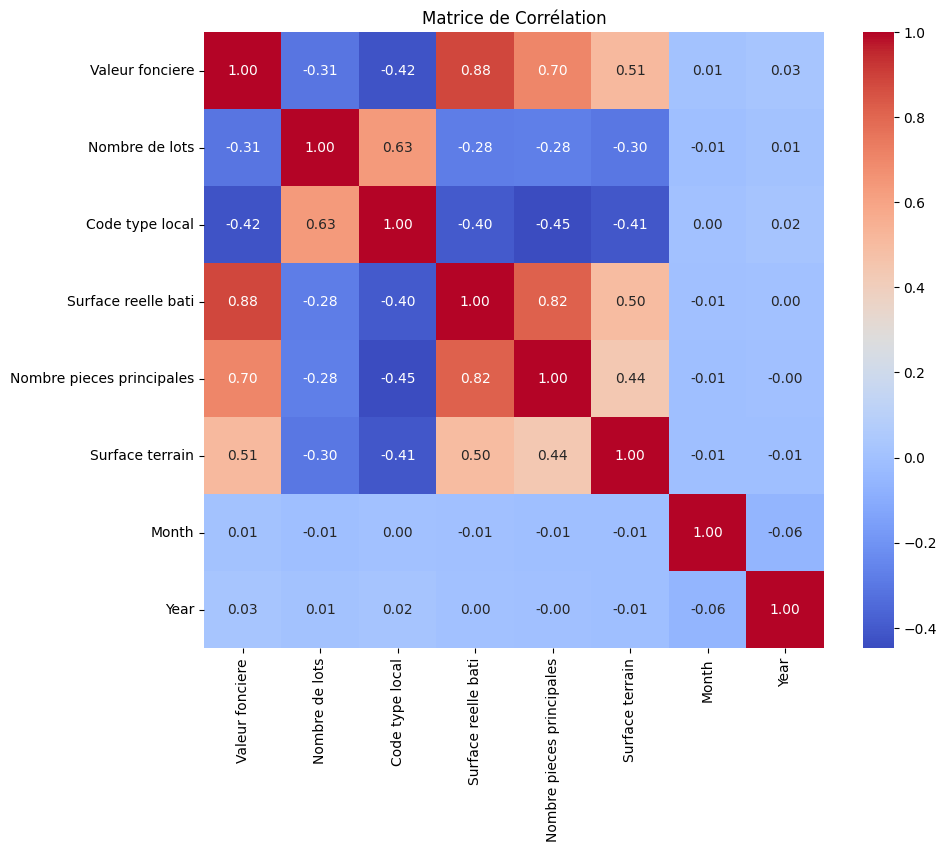

In [189]:
# Utilisation de Seaborn pour créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    dataframe_grouped.drop(columns = ["Section"]).corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm')

# Affichage du graphique
plt.title("Matrice de Corrélation")
plt.show()

In [190]:
dataframe_grouped

,Valeur fonciere,Section,Nombre de lots,Code type local,Surface reelle bati,Nombre pieces principales,Surface terrain,Month,Year
adresse,,,,,,,,,
1.0 ALL BLERIOT 33200.02021-05-25 00:00:00421800,421800,YE,0,1.0,82.0,3.0,414.0,5,2021
1.0 ALL CORNEILLE 33200.02020-07-24 00:00:00550000,550000,NH,0,1.0,98.0,4.0,589.0,7,2020
1.0 ALL DAVEZAC 33200.02020-09-04 00:00:00600000,600000,YH,1,1.0,130.0,3.0,131.0,9,2020
1.0 ALL RONSARD 33200.02020-05-25 00:00:00152000,152000,OB,1,2.0,33.0,1.0,34.0,5,2020
1.0 ALL RONSARD 33200.02021-04-12 00:00:00206000,206000,OB,1,2.0,51.0,2.0,52.0,4,2021
...,...,...,...,...,...,...,...,...,...
nan PL PAUL ET JEAN PAUL AVISSEAU 33300.02020-11-19 00:00:00119000,119000,RH,1,2.0,34.0,2.0,35.0,11,2020
nan PL PAUL ET JEAN PAUL AVISSEAU 33300.02020-12-22 00:00:0077000,77000,RH,1,2.0,20.0,1.0,21.0,12,2020
nan PL PAUL ET JEAN PAUL AVISSEAU 33300.02021-01-14 00:00:0077000,77000,RH,1,2.0,20.0,1.0,21.0,1,2021


In [191]:
dataframe_grouped = dataframe_grouped.drop(columns = ["Surface terrain", "Nombre pieces principales"])

In [192]:
from sklearn.model_selection import train_test_split

In [193]:
X = dataframe_grouped.drop(columns = ["Valeur fonciere"])
y = dataframe_grouped[["Valeur fonciere"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=123)
nb_section = X_train.groupby("Section")[["Code type local"]].agg("count").sort_values(by = "Code type local").reset_index()



In [194]:
X_train

,Section,Nombre de lots,Code type local,Surface reelle bati,Month,Year
adresse,,,,,,
36.0 RUE DE LACANAU 33000.02021-08-20 00:00:00275000,LY,0,1.0,47.0,8,2021
7.0 SEN ARMANDE LACAZE 33100.02022-08-02 00:00:00320000,AF,1,2.0,61.0,8,2022
88.0 RUE GEORGES MANDEL 33000.02021-04-13 00:00:00412000,LW,0,1.0,84.0,4,2021
88.0 CRS D ALSACE LORRAINE 33000.02021-08-10 00:00:00475000,HD,1,2.0,81.0,8,2021
2.0 RUE DES ALLAMANDIERS 33800.02021-07-27 00:00:00237500,DN,2,2.0,41.0,7,2021
...,...,...,...,...,...,...
55.0 RUE MAURICE 33300.02021-03-26 00:00:00170000,RP,2,2.0,45.0,3,2021
11.0 RUE SEGALIER 33000.02020-10-14 00:00:00375000,LA,1,2.0,73.0,10,2020
5.0 RUE MILLANGES 33000.02020-02-04 00:00:00155150,KI,1,2.0,28.0,2,2020


In [195]:
type(gdf1)

geopandas.geodataframe.GeoDataFrame

In [196]:
df_section_grouped = df_section_grouped(df_nb_section = nb_section, df_section_geometry = gdf1, n_min = 100)

section_faible 371
gdf 390


section_faible 130
gdf 172
section_faible 22
gdf 90
section_faible 1
gdf 72


In [197]:
df_section_grouped.columns

Index(['Section', 'geometry_grouped', 'centroid_grouped', 'touches_polygon',
       'Section_grouped', 'lon_lat_grouped', 'longitude_grouped',
       'latitude_grouped', 'geometry', 'centroid', 'lon_lat', 'longitude',
       'latitude', 'distance'],
      dtype='object')

In [198]:
# Fonction de normalisation Min-Max
def normalize(X):
    min_vals = X.min()
    max_vals = X.max()
    X_normalized = (X - min_vals) / (max_vals - min_vals)
    return X_normalized

# Application de la fonction de normalisation
#df_section_grouped[['longitude_grouped', 'latitude_grouped', 'longitude', 'latitude', 'distance']] = df_section_grouped[['longitude_grouped', 'latitude_grouped', 'longitude', 'latitude', 'distance']].apply(normalize, axis=0)


In [199]:
# activate Bokeh output in Jupyter notebook
from bokeh.io import output_notebook

output_notebook()
# Assurez-vous que 'geometry_grouped' est la colonne de géométrie
df_section_grouped_plt = df_section_grouped[["Section_grouped","geometry_grouped"]].drop_duplicates()

def extract_xy(poly):
    """
    Extrait les coordonnées x et y d'un polygone Shapely pour Bokeh.
    """
    if isinstance(poly, Polygon):
        return list(poly.exterior.coords.xy)
    else:
        return None, None

# Appliquez cette fonction à votre DataFrame
df_section_grouped_plt['xs'], df_section_grouped_plt['ys'] = zip(*df_section_grouped_plt['geometry_grouped'].apply(extract_xy))
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource

# Convertir les données en source pour Bokeh
source = ColumnDataSource(df_section_grouped_plt[["Section_grouped", "xs", "ys"]])

# Calculer les limites pour la figure
min_x = min(df_section_grouped_plt['xs'].apply(min))
max_x = max(df_section_grouped_plt['xs'].apply(max))
min_y = min(df_section_grouped_plt['ys'].apply(min))
max_y = max(df_section_grouped_plt['ys'].apply(max))

# Créer la figure avec des limites spécifiques
p = figure(x_range=(min_x, max_x), y_range=(min_y, max_y), title="Visualisation des Polygones")

# Tracer les polygones
p.patches('xs', 'ys', source=source, fill_alpha=0.6, line_color="black")

# Afficher le résultat
show(p)

Loading BokehJS ...

In [200]:
X_train

,Section,Nombre de lots,Code type local,Surface reelle bati,Month,Year
adresse,,,,,,
36.0 RUE DE LACANAU 33000.02021-08-20 00:00:00275000,LY,0,1.0,47.0,8,2021
7.0 SEN ARMANDE LACAZE 33100.02022-08-02 00:00:00320000,AF,1,2.0,61.0,8,2022
88.0 RUE GEORGES MANDEL 33000.02021-04-13 00:00:00412000,LW,0,1.0,84.0,4,2021
88.0 CRS D ALSACE LORRAINE 33000.02021-08-10 00:00:00475000,HD,1,2.0,81.0,8,2021
2.0 RUE DES ALLAMANDIERS 33800.02021-07-27 00:00:00237500,DN,2,2.0,41.0,7,2021
...,...,...,...,...,...,...
55.0 RUE MAURICE 33300.02021-03-26 00:00:00170000,RP,2,2.0,45.0,3,2021
11.0 RUE SEGALIER 33000.02020-10-14 00:00:00375000,LA,1,2.0,73.0,10,2020
5.0 RUE MILLANGES 33000.02020-02-04 00:00:00155150,KI,1,2.0,28.0,2,2020


In [201]:
nb_sec = len(X_train["Section"].unique())
nb_sec

337

In [202]:
df_section_grouped_long_lat = df_section_grouped[["Section","longitude", "latitude", "longitude_grouped", "latitude_grouped", "distance"]]

X_train = X_train.merge(df_section_grouped_long_lat, on = "Section", how = "left", validate = "many_to_one").drop(columns = ["Section"])
X_test = X_test.merge(df_section_grouped_long_lat, on = "Section", how = "left", validate = "many_to_one").drop(columns = ["Section"])




In [203]:
pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis =1)

,Nombre de lots,Code type local,Surface reelle bati,Month,Year,longitude,latitude,longitude_grouped,latitude_grouped,distance,Valeur fonciere
0,0,1.0,47.0,8,2021,-0.593841,44.838189,-0.593293,44.835957,251.655299,275000
1,1,2.0,61.0,8,2022,-0.550426,44.852045,-0.549737,44.848175,433.213476,320000
2,0,1.0,84.0,4,2021,-0.591573,44.841696,-0.588665,44.840987,242.972079,412000
3,1,2.0,81.0,8,2021,-0.573034,44.836324,-0.573034,44.836324,0.000000,475000
4,2,2.0,41.0,7,2021,-0.564885,44.832920,-0.563283,44.831172,231.818120,237500
...,...,...,...,...,...,...,...,...,...,...,...
12608,2,2.0,45.0,3,2021,-0.565251,44.858516,-0.561898,44.854299,538.049939,170000
12609,1,2.0,73.0,10,2020,-0.587557,44.841981,-0.588665,44.840987,140.952721,375000
12610,1,2.0,28.0,2,2020,-0.573497,44.838273,-0.573438,44.839001,80.938586,155150
12611,4,2.0,96.0,11,2020,-0.583616,44.842692,-0.579789,44.843241,308.492921,545000


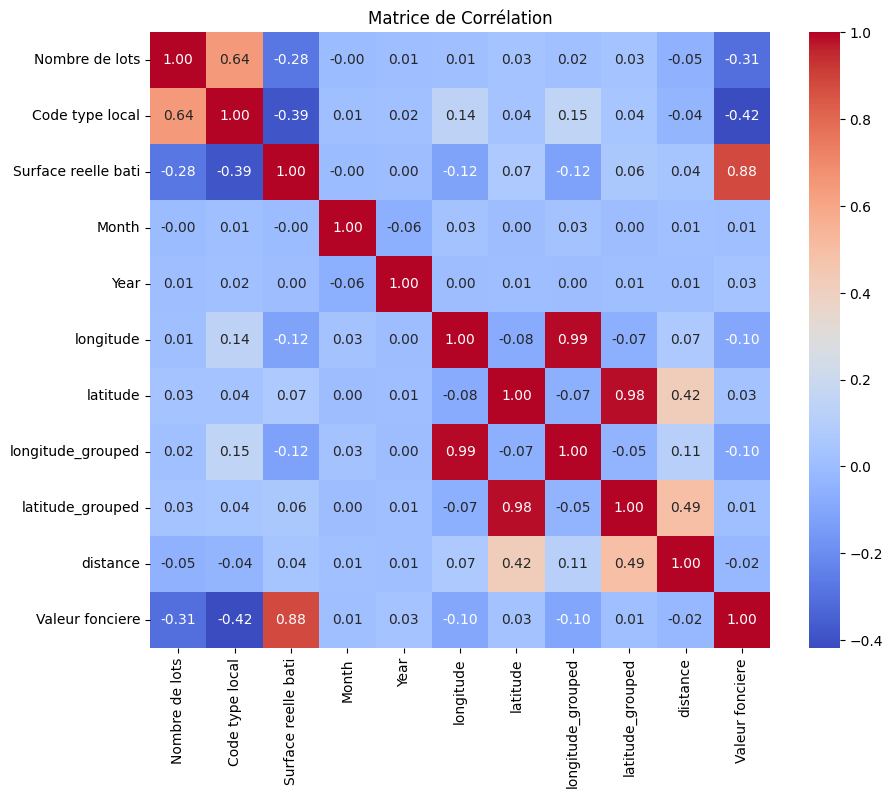

In [204]:
# Utilisation de Seaborn pour créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis =1).corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm')

# Affichage du graphique
plt.title("Matrice de Corrélation")
plt.show()

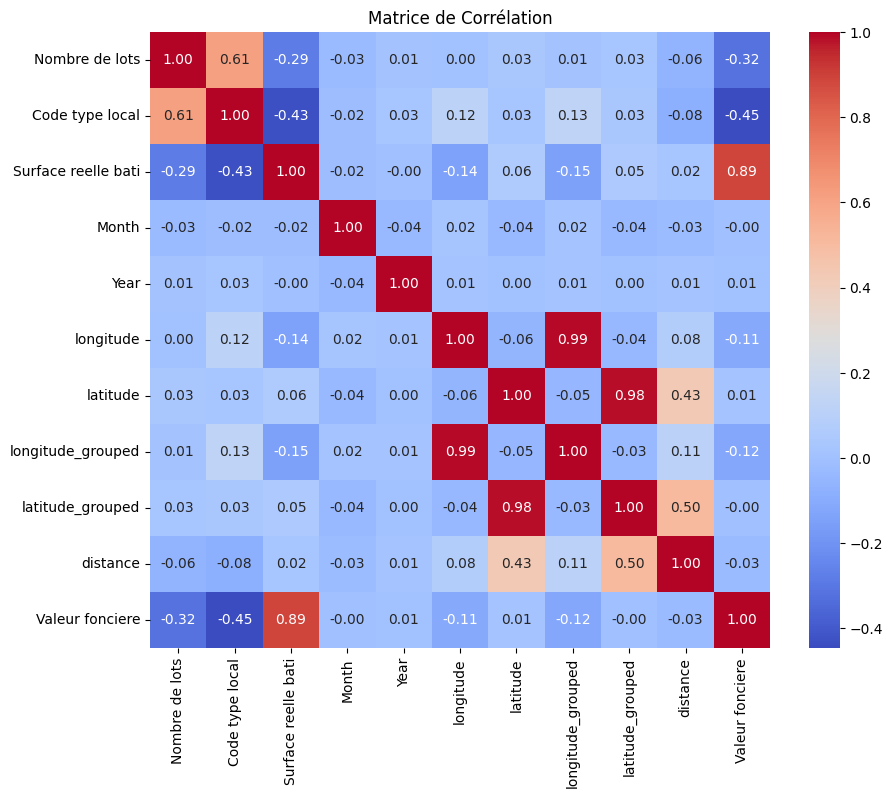

In [205]:
# Utilisation de Seaborn pour créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True)], axis = 1).corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm')

# Affichage du graphique
plt.title("Matrice de Corrélation")
plt.show()

In [206]:
X_train.columns

Index(['Nombre de lots', 'Code type local', 'Surface reelle bati', 'Month',
       'Year', 'longitude', 'latitude', 'longitude_grouped',
       'latitude_grouped', 'distance'],
      dtype='object')

In [207]:
X_train[['Nombre de lots', 'Code type local', 'Surface reelle bati', 'Month','Year']] = X_train[['Nombre de lots', 'Code type local', 'Surface reelle bati', 'Month','Year']].apply(normalize, axis = 0)

In [208]:
y_test

,Valeur fonciere
adresse,
12.0 RUE SAINT JAMES 33000.02022-11-16 00:00:00123000,123000
282.0 RUE DE TURENNE 33000.02022-09-05 00:00:00211800,211800
1.0 RUE JEAN JACQUES BEL 33000.02021-05-05 00:00:00660000,660000
8.0 RUE ROSALIE 33800.02020-09-08 00:00:00182300,182300
50.0B RUE DES LIEGES 33200.02020-01-09 00:00:00206400,206400
...,...
22.0 RUE DES BLEUETS CAUD 33200.02021-01-06 00:00:00450000,450000
199.0 AV D ARES 33200.02021-10-26 00:00:00362500,362500
214.0 RUE SAINT GENES 33000.02021-07-12 00:00:001194900,1194900


In [209]:
X_train1 = X_train.drop(columns = ["longitude_grouped", "latitude_grouped"])
X_train2 = X_train.drop(columns = ["longitude", "latitude"])

X_test1 = X_test.drop(columns = ["longitude_grouped", "latitude_grouped"])
X_test2 = X_test.drop(columns = ["longitude", "latitude"])

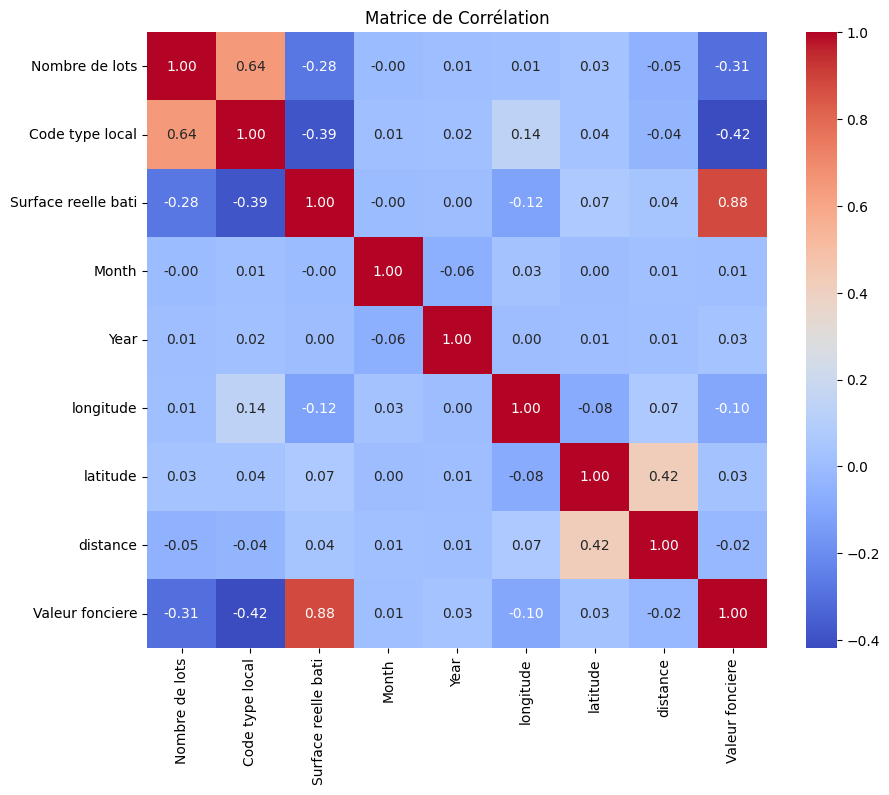

In [210]:
# Utilisation de Seaborn pour créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.concat([X_train1.reset_index(drop = True), y_train.reset_index(drop = True)], axis =1).corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm')

# Affichage du graphique
plt.title("Matrice de Corrélation")
plt.show()

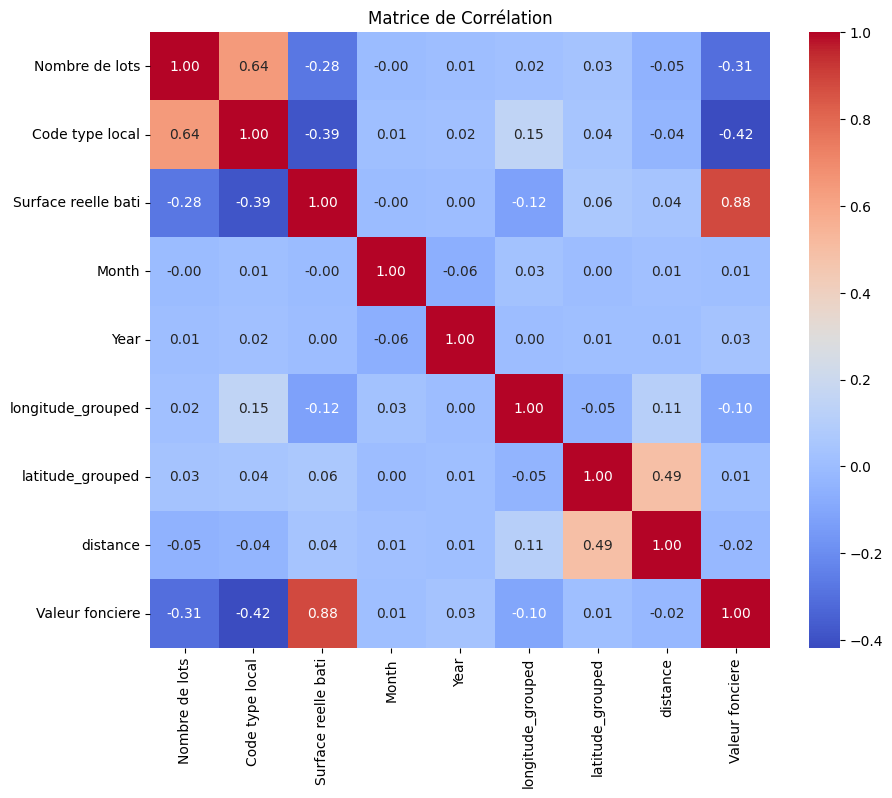

In [211]:
# Utilisation de Seaborn pour créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.concat([X_train2.reset_index(drop = True), y_train.reset_index(drop = True)], axis =1).corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm')

# Affichage du graphique
plt.title("Matrice de Corrélation")
plt.show()

In [212]:
X_test

,Nombre de lots,Code type local,Surface reelle bati,Month,Year,longitude,latitude,longitude_grouped,latitude_grouped,distance
0,1,2.0,50.0,11,2022,-0.573034,44.836324,-0.573034,44.836324,0.000000
1,2,2.0,35.0,9,2022,-0.594572,44.848209,-0.592483,44.845876,307.223350
2,1,2.0,86.0,5,2021,-0.576930,44.843185,-0.579789,44.843241,225.982677
3,1,2.0,45.0,9,2020,-0.551852,44.825559,-0.546968,44.827306,432.065723
4,1,1.0,48.0,1,2020,-0.627765,44.849001,-0.629899,44.851173,294.298758
...,...,...,...,...,...,...,...,...,...,...
3553,0,1.0,75.0,1,2021,-0.636763,44.859015,-0.633672,44.859451,248.933123
3554,2,2.0,84.0,10,2021,-0.606497,44.837694,-0.607277,44.841589,437.061793
3555,0,1.0,180.0,7,2021,-0.583303,44.822688,-0.583327,44.826537,427.504625
3556,0,1.0,96.0,8,2022,-0.567310,44.813045,-0.568896,44.814243,182.882416


In [213]:
len(X_train["longitude_grouped"].unique())

71

In [214]:
max(y_test["Valeur fonciere"])

3220000

In [243]:
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Définition du modèle
model = Sequential([
    Dense(64, activation='linear', input_shape=(X_train.shape[1],)),
    Dense(32, activation='linear'),
    Dense(16, activation='linear'),
    Dense(4, activation='linear'),
    Dense(1, activation='linear')
])

# Configuration de l'optimiseur Nadam
optimizer = Adam(learning_rate=0.001)

# Compilation du modèle
model.compile(optimizer=optimizer, loss = 'mean_squared_error', metrics='mae')


model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),)

Epoch 1/50
395/395 [==============================] - 3s 3ms/step - loss: 152431771648.0000 - mae: 259742.5938 - val_loss: 3857211719680.0000 - val_mae: 1944920.6250
Epoch 2/50
395/395 [==============================] - 1s 3ms/step - loss: 104982847488.0000 - mae: 201360.8906 - val_loss: 34762471243776.0000 - val_mae: 5893611.0000
Epoch 3/50
395/395 [==============================] - 1s 3ms/step - loss: 88796815360.0000 - mae: 194810.1094 - val_loss: 60778853957632.0000 - val_mae: 7794964.5000
Epoch 4/50
395/395 [==============================] - 1s 3ms/step - loss: 88142667776.0000 - mae: 194898.0781 - val_loss: 71007670894592.0000 - val_mae: 8424896.0000
Epoch 5/50
395/395 [==============================] - 1s 3ms/step - loss: 88008916992.0000 - mae: 194623.3281 - val_loss: 74517707751424.0000 - val_mae: 8629732.0000
Epoch 6/50
395/395 [==============================] - 1s 3ms/step - loss: 87865819136.0000 - mae: 194473.8594 - val_loss: 86224865853440.0000 - val_mae: 9281510.0000
Epo